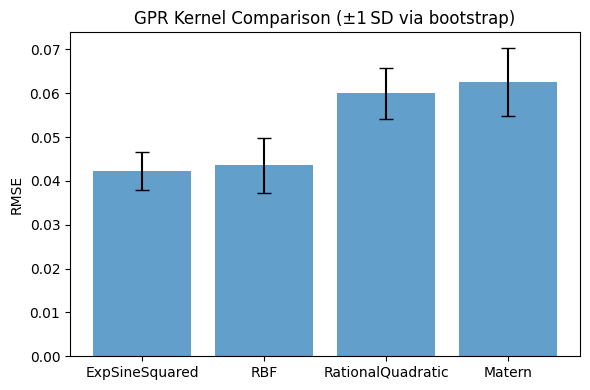

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    Matern,
    RationalQuadratic,
    ExpSineSquared,
    WhiteKernel,
    ConstantKernel as C
)
from sklearn.metrics import mean_squared_error

# 1) Load training data
df1 = pd.read_csv('./TemporalSelection-CHI2023/study1_data.csv')
df2 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_jump.csv')
df_train = pd.concat([df1, df2], ignore_index=True)

# 2) Prepare features & target
features = ['D_t', 'W_t', 'R_t']
X_train = df_train[features].values
y_train = df_train['PressedTime'].values

# 3) Standardize X
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)

# 4) Define kernels
kernel_list = {
    "RBF": (
        C(1.0, (1e-3,1e3)) * RBF(length_scale=[1,1,1], length_scale_bounds=(1e-2,1e2))
        + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-5,1e1))
    ),
    "Matern": (
        C(1.0, (1e-3,1e3)) * Matern(length_scale=[1,1,1], nu=1.5)
        + WhiteKernel(noise_level=1.0)
    ),
    "RationalQuadratic": (
        C(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)
        + WhiteKernel(noise_level=1.0)
    ),
    "ExpSineSquared": (
        C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=3.0)
        + WhiteKernel(noise_level=1.0)
    )
}

# 5) Load & aggregate Study3
df3 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_space.csv')
emp3 = (
    df3
    .groupby(features)['PressedTime']
    .mean()
    .reset_index()
    .rename(columns={'PressedTime':'empirical_mean'})
)
X_test = emp3[features].values
X_test_s = scaler_X.transform(X_test)

# 6) Fit, predict, bootstrap RMSE
B = 100  # number of bootstrap resamples
results = []

for name, kernel in kernel_list.items():
    # fit GPR
    gpr = GaussianProcessRegressor(
        kernel=kernel,
        normalize_y=True,
        n_restarts_optimizer=5,
        random_state=0
    )
    idx = np.random.choice(len(X_train_s), size=1000, replace=False)
    gpr.fit(X_train_s[idx], y_train[idx])
    
    # predict once on the full grid for the “point” RMSE
    gp_mean_full, _ = gpr.predict(X_test_s, return_std=True)
    rmse_full = np.sqrt(mean_squared_error(emp3['empirical_mean'], gp_mean_full))
    
    # bootstrap to get RMSE distribution
    rmse_boot = []
    n_test = len(emp3)
    for b in range(B):
        samp_idx = np.random.choice(n_test, size=n_test, replace=True)
        rmse_b = np.sqrt(
            mean_squared_error(
                emp3['empirical_mean'].values[samp_idx],
                gp_mean_full[samp_idx]
            )
        )
        rmse_boot.append(rmse_b)
    rmse_std = np.std(rmse_boot, ddof=1)
    
    results.append({
        'kernel': name,
        'rmse': rmse_full,
        'rmse_std': rmse_std
    })

# 7) Summarize & plot with error bars
results_df = pd.DataFrame(results).sort_values('rmse')




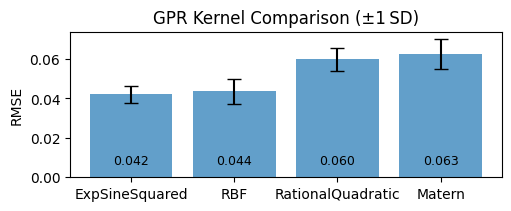

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 2))
bars = ax.bar(
    results_df['kernel'],
    results_df['rmse'],
    yerr=results_df['rmse_std'],
    capsize=5,
    alpha=0.7
)

# annotate each bar with its rmse value just above the error bar
for idx, bar in enumerate(bars):
    rmse_val = results_df['rmse'].iloc[idx]
    err     = results_df['rmse_std'].iloc[idx]
    x       = bar.get_x() + bar.get_width() / 2
    y       = 0.005  # small offset above the error bar
    ax.text(
        x, y,
        f"{rmse_val:.3f}",
        ha='center',
        va='bottom',
        fontsize= 9,  # e.g. 9 or 10
    )

ax.set_ylabel('RMSE')
ax.set_title('GPR Kernel Comparison (±1 SD)')
plt.tight_layout(pad=0.3)
plt.show()


Trained GP kernel: 1.3**2 * ExpSineSquared(length_scale=0.0464, periodicity=213) + WhiteKernel(noise_level=0.194)


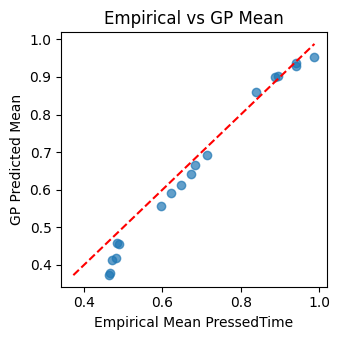

In [ ]:
# %%  Train on Study1 + Study2, test on Study3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C

# 1) Load training data
# Adjust these paths if your CSVs live elsewhere
df1 = pd.read_csv('./TemporalSelection-CHI2023/study1_data.csv')
df2 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_jump.csv')
df_train = pd.concat([df1, df2], ignore_index=True)

# 2) Prepare features & target
features = ['D_t','W_t','R_t']
X_train = df_train[features].values
y_train = df_train['PressedTime'].values

# 3) Fit scaler + GP
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)

kernel = (
  C(1.0) * ExpSineSquared(length_scale=1.0, periodicity=3.0)
                      + WhiteKernel(noise_level=1.0)
)
gpr = GaussianProcessRegressor(kernel=kernel,
                               n_restarts_optimizer=5,
                               normalize_y=True)
idx = np.random.choice(len(X_train_s), size=1000, replace=False)
gpr.fit(X_train_s[idx], y_train[idx])
#gpr.fit(X_train_s, y_train)
print("Trained GP kernel:", gpr.kernel_)

# 4) Load & aggregate Study3 (test) data
df3 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_space.csv')
emp3 = (
    df3
    .groupby(features)['PressedTime']
    .mean()
    .reset_index()
    .rename(columns={'PressedTime':'empirical_mean'})
)

# 5) GP prediction on those combos
X_test_s = scaler_X.transform(emp3[features].values)
gp_mean, gp_std = gpr.predict(X_test_s, return_std=True)
emp3['gp_pred_mean'] = gp_mean
emp3['gp_pred_std']  = gp_std


# 7) Plot empirical vs. predicted means
plt.figure(figsize=(3.5,3.5))
plt.scatter(emp3['empirical_mean'], emp3['gp_pred_mean'], alpha=0.7)
mn, mx = emp3[['empirical_mean','gp_pred_mean']].values.min(), emp3[['empirical_mean','gp_pred_mean']].values.max()
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel('Empirical Mean PressedTime')
plt.ylabel('GP Predicted Mean')
plt.title('Empirical vs GP Mean')
plt.tight_layout()
plt.show()


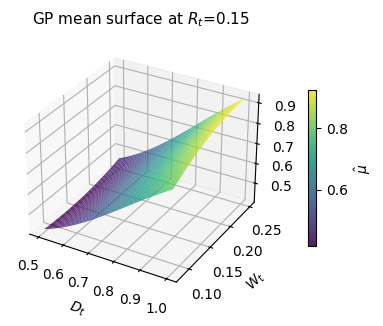

In [89]:
from mpl_toolkits.mplot3d import Axes3D

# 1) Choose a slice value for R_t (e.g. median of your test‐set R_t’s)
R0 = emp3['R_t'].median()

# 2) Build a grid over D_t and W_t
d_min, d_max = emp3['D_t'].min(), emp3['D_t'].max()
w_min, w_max = emp3['W_t'].min(), emp3['W_t'].max()
d_lin = np.linspace(d_min, d_max, 50)
w_lin = np.linspace(w_min, w_max, 50)
Dg, Wg = np.meshgrid(d_lin, w_lin)

# 3) Pack into (N×3) array, standardize, predict
grid = np.column_stack([
    Dg.ravel(),
    Wg.ravel(),
    np.full(Dg.size, R0)
])
grid_s = scaler_X.transform(grid)
mu_grid, _ = gpr.predict(grid_s, return_std=True)
Mu = mu_grid.reshape(Dg.shape)

# 4) Plot
fig = plt.figure(figsize=(4,3))
ax  = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(
    Dg, Wg, Mu,
    linewidth=0, antialiased=True, alpha=0.9, cmap='viridis'
)
ax.set_xlabel(r'$D_t$', labelpad=5, fontsize=10)
ax.set_ylabel(r'$W_t$', labelpad=5, fontsize=10)
#ax.set_zlabel(r'$\hat\mu$', labelpad=5, fontsize=10)
ax.set_title(f'GP mean surface at $R_t$={R0:.2f}', pad=10, fontsize=11)

fig.colorbar(surf, shrink=0.6, pad=0.1, label=r'$\hat\mu$')
plt.tight_layout(pad=0.4)
plt.show()


Overall RMSE = 0.8081


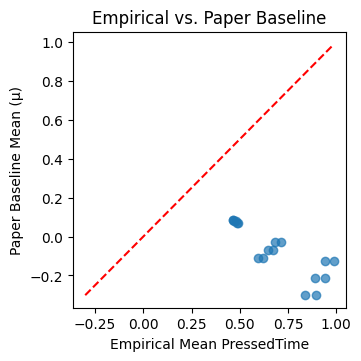


At D_t=0.2, W_t=0.5, R_t=1.0:
Empty DataFrame
Columns: [empirical_mean, predicted_mean]
Index: []


In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Load Study3
df3 = pd.read_csv('./TemporalSelection-CHI2023/study2_data_space.csv')

# 2) Empirical means by (D_t, W_t, R_t)
features = ['D_t','W_t','R_t']
emp3 = (
    df3
    .groupby(features)['PressedTime']
    .mean()
    .reset_index()
    .rename(columns={'PressedTime':'empirical_mean'})
)

# 3) Predicted mean from your linear‐interaction model:
#    μ = 0.063 − 0.014·D_t + 2.046·R_t − 3.798·(D_t·R_t)
emp3['predicted_mean'] = (
      0.063
    - 0.014 * emp3['D_t']
    + 2.046 * emp3['R_t']
    - 3.798 * (emp3['D_t'] * emp3['R_t'])
)

# 4) Compute RMSE over all (D,W,R)
rmse = np.sqrt(np.mean((emp3['empirical_mean'] - emp3['predicted_mean'])**2))
print(f"Overall RMSE = {rmse:.4f}")

# 5) Scatter‐plot empirical vs. predicted
plt.figure(figsize=(3.5,3.5))
plt.scatter(emp3['empirical_mean'], emp3['predicted_mean'], alpha=0.7)
mn = min(emp3['empirical_mean'].min(), emp3['predicted_mean'].min())
mx = max(emp3['empirical_mean'].max(), emp3['predicted_mean'].max())
plt.plot([mn,mx],[mn,mx],'r--')
plt.xlabel('Empirical Mean PressedTime')
plt.ylabel('Paper Baseline Mean (μ)')
# plt.title(f'Empirical vs. Paper Baseline (RMSE={rmse:.3f})')
plt.title(f'Empirical vs. Paper Baseline')

plt.tight_layout(pad=0.3)
plt.show()

# 6) Compare at one fixed (d,w,r), e.g. d=0.2, w=0.5, r=1.0
d_val, w_val, r_val = 0.2, 0.5, 1.0
row = emp3.query("D_t==@d_val & W_t==@w_val & R_t==@r_val")
print(f"\nAt D_t={d_val}, W_t={w_val}, R_t={r_val}:")
print(row[['empirical_mean','predicted_mean']])
